In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iEEG_utils.loading import read_data
from iEEG_utils.processing import filtering
import pymultitaper # https://github.com/fncokg/pymultitaper

rng = np.random.default_rng()

In [2]:
# use file selection dialog to choose folder with data storage
fstr = read_data.select_directory()
print(fstr)

C:\Users\jmile3\OneDrive - SCH\sEEG_data\Thalamic\2398ec


In [14]:
# if following JTM's data processing workflow
#### i.e.: 
#### iEEG.csv of timeseries for regions of interest
#### montage.csv of research montage info
#### channels.csv with metadata (loosely following iEEG-BIDS)
# the next line will load the iEEG.csv file and metadata
# can set load_meta = False to just load the timeseries data
# will need sampling rate, though (typically in "channels.csv")

montage = read_data.load_info(fstr,ftype="montage")
montage.name = montage.name.replace(" ","",regex=True)
srate,data = read_data.load_iEEG(fstr,load_meta=True)
# newcols = list(map(lambda x: x.replace(" ",""),data.columns))
data.rename(mapper=dict(zip(data.columns,list(map(lambda x: x.replace(" ",""),data.columns)))),axis='columns',inplace=True)
origtime = pd.to_datetime(data.time,format='%H:%M:%S.%f')
origts = np.array(origtime-origtime[0])/ np.timedelta64(1, 's')

print(srate)
print(data.shape)

display(data.head())

1000
(302000, 20)


,time,LCM3,LCM4,LCM5,LCM6,LCM7,LCM8,LCM12,LCM13,LCM14,RCM3,RCM4,LANT3,LANT4,LANT15,LANT16,RANT1,RANT2,DC1,DC2
0,10:59:28.948976,-1.170983,-4.188510,-8.681272,-9.351833,-14.582213,-7.206036,-7.071924,-4.188510,19.817593,-4.859071,-6.870756,4.528790,-10.290620,5.735801,4.327622,2.382993,-7.273093,-110.271344,-117.513408
1,10:59:28.949976,-6.267250,-8.614216,-13.039922,-14.448101,-17.532684,-9.418890,-13.643427,-7.876598,16.062449,-11.430574,-11.967023,0.103084,-13.911652,1.310095,0.639533,-2.780330,-10.223563,-132.668099,-131.192864
2,10:59:28.950976,-9.217721,-11.564686,-13.777539,-17.398572,-19.745537,-10.827069,-17.264459,-10.827069,13.849596,-15.051606,-14.112820,-2.176825,-17.532684,-2.310937,-2.981499,-6.401363,-13.106978,-109.869007,-97.396563
3,10:59:28.951976,-10.625900,-10.089451,-13.039922,-15.923336,-20.483155,-9.418890,-15.789224,-12.235248,15.257775,-14.984550,-14.112820,-2.914443,-16.795066,-3.786173,-4.456734,-2.780330,-13.106978,-79.760794,-52.737164
4,10:59:28.952976,-12.101136,-10.827069,-16.660954,-18.806751,-22.696008,-12.302304,-18.002077,-15.923336,14.520157,-14.984550,-16.258617,-5.127296,-18.940863,-7.407205,-8.144823,-4.926127,-14.582213,-56.291141,-18.404414


In [17]:
montage

,ID,age,region,ch,name
0,2398ec,19.92,r_centromedian_thal,18,RCM3
1,2398ec,19.92,r_centromedian_thal,19,RCM4
2,2398ec,19.92,l_centromedian_thal,2,LCM3
3,2398ec,19.92,l_centromedian_thal,3,LCM4
4,2398ec,19.92,l_ventroposterolateral_thal,4,LCM5
5,2398ec,19.92,l_ventroposterolateral_thal,5,LCM6
6,2398ec,19.92,l_ventrallateralposterior_thal,6,LCM7
7,2398ec,19.92,l_ventrallateralposterior_thal,7,LCM8
8,2398ec,19.92,l_caudalmiddlefrontal,11,LCM12
9,2398ec,19.92,l_caudalmiddlefrontal,12,LCM13


In [28]:
resrate = 1024
lpfreq = 150
ch1 = "LCM13"
ch2 = "LCM14"
ts,reref = filtering.bipolar_reref(data.loc[:,[ch1,ch2]], srate, resrate, lpfreq=lpfreq)


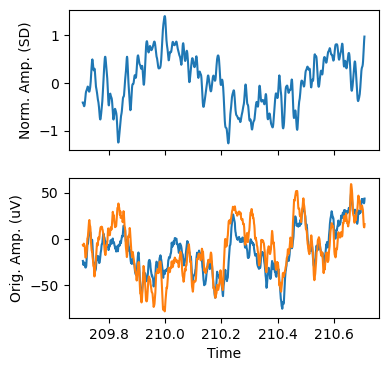

In [35]:
t1 = rng.integers(resrate, high=len(reref))
t0 = t1-resrate
tfilt = (origts>=ts[t0]) & (origts<=ts[t1])
fig, ax = plt.subplots(2,1,sharex=True,figsize=[4,4])
ax[0].plot(ts[t0:t1],reref[t0:t1])
ax[1].plot(origts[tfilt], filtering.bfilt(np.array([data.loc[tfilt,ch2],data.loc[tfilt,ch1]]).T,srate,4,[59,61],"stop"))
ax[0].set_xlabel("")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Norm. Amp. (SD)")
ax[1].set_ylabel("Orig. Amp. (uV)")
plt.show()